![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/14.German_Healthcare_Models.ipynb)

## Colab Setup

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import json
import os

import sparknlp_jsl
import sparknlp

from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType
import itertools

from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp_jsl.annotator import *

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 6.1.3
Spark NLP_JSL Version : 6.1.1


## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## Clinical Named Entitiy Recognition (NER)

We have two different German Clinical NER:

- ner_healthcare

```
['MEDICATION',
 'BODY_PART',
 'MEDICAL_CONDITION',
 'STATE_OF_HEALTH',
 'BODY_FLUID',
 'BIOLOGICAL_PARAMETER',
 'MEASUREMENT',
 'TREATMENT',
 'BIOLOGICAL_CHEMISTRY',
 'TIME_INFORMATION',
 'PERSON',
 'MEDICAL_SPECIFICATION',
 'PROCESS',
 'DIAGLAB_PROCEDURE',
 'DOSING',
 'MEDICAL_DEVICE',
 'LOCAL_SPECIFICATION',
 'TISSUE',
 'DEGREE']
 ```

- ner_healthcare_slim

```
['TIME_INFORMATION',
 'MEDICAL_CONDITION',
 'BODY_PART',
 'TREATMENT',
 'PERSON',
 'BODY_PART']
```


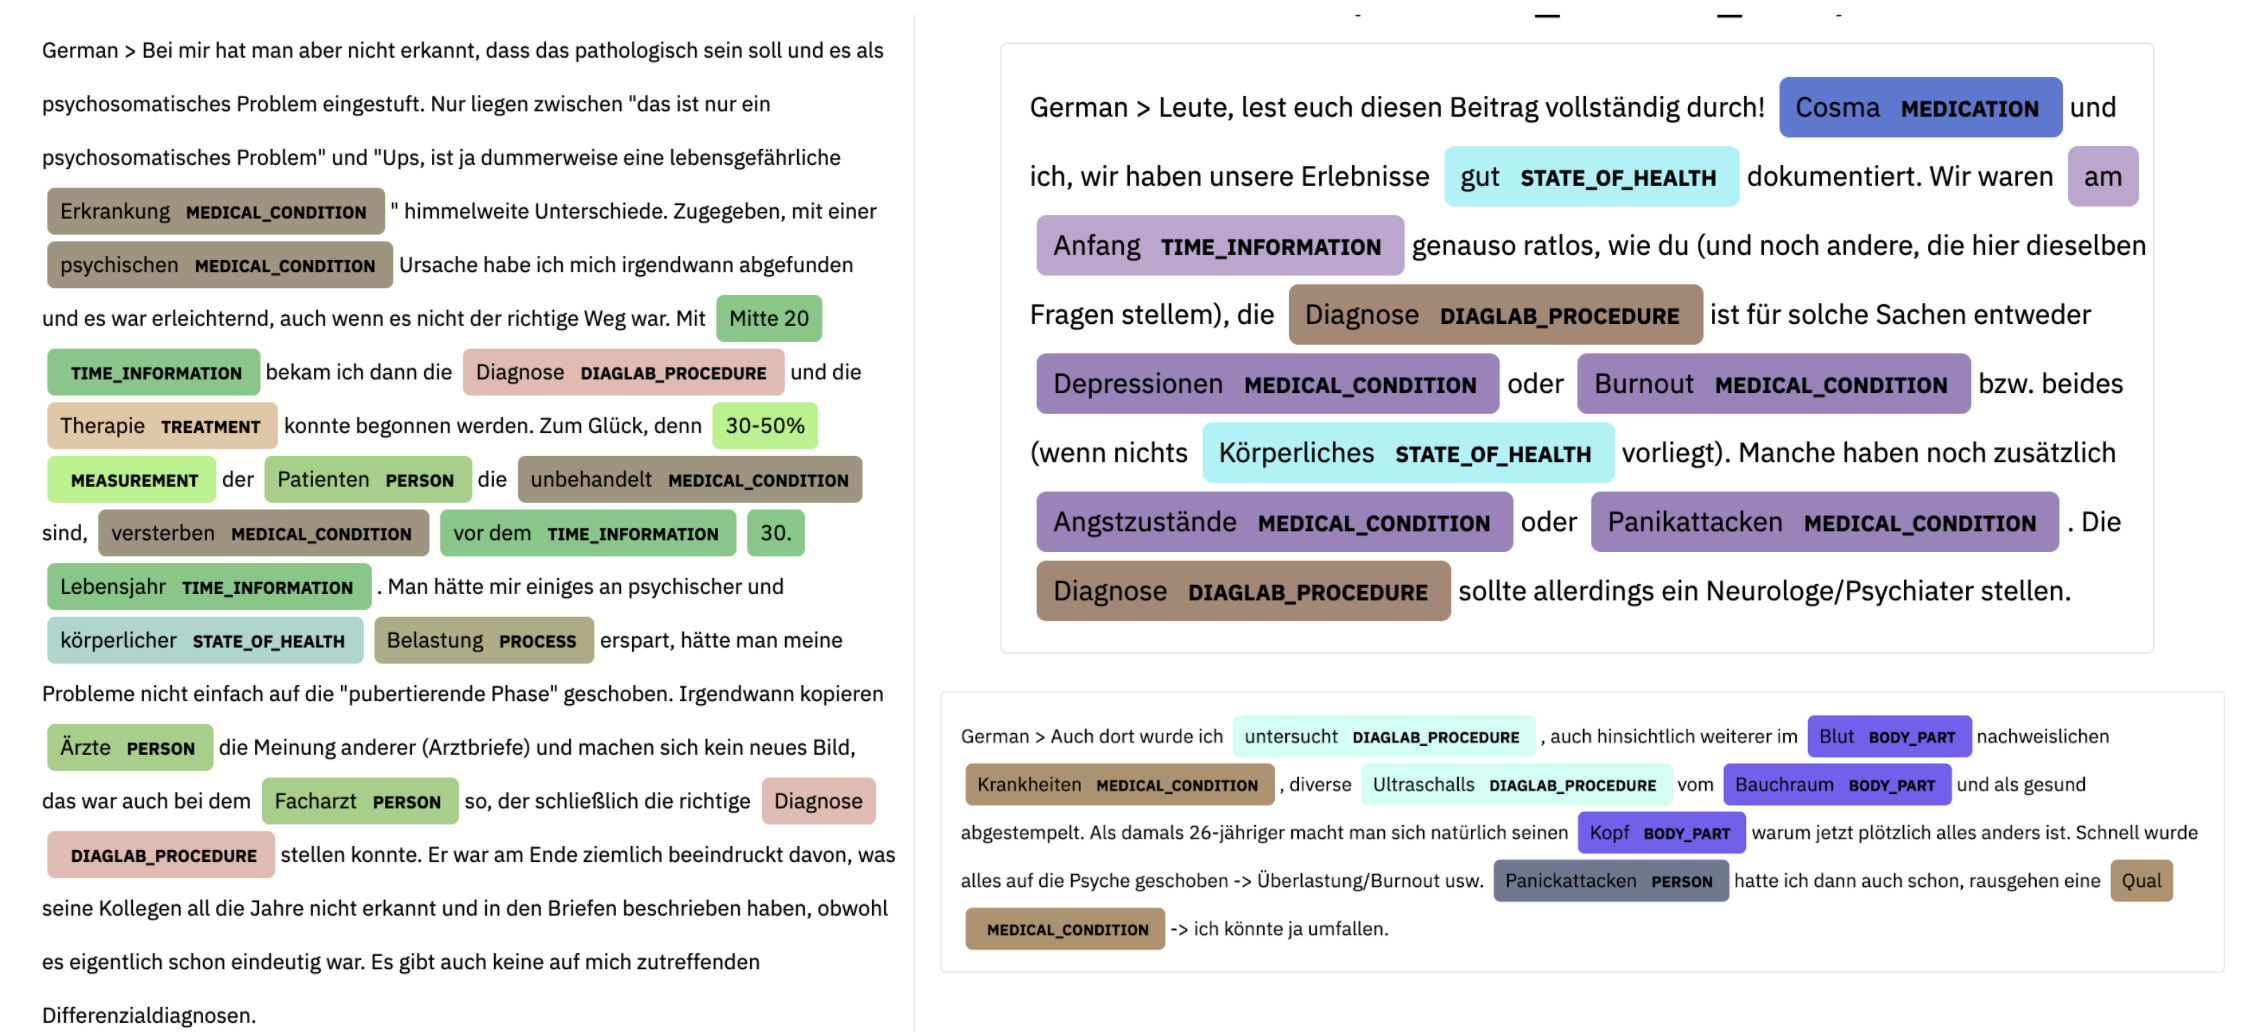

- ner_oncology_wip

```
['Histological_Type', 'Direction', 'Staging',
'Cancer_Score', 'Imaging_Test', 'Cycle_Number',
'Tumor_Finding', 'Site_Lymph_Node', 'Invasion',
'Response_To_Treatment', 'Smoking_Status', 'Tumor_Size',
'Cycle_Count', 'Adenopathy', 'Age',
'Biomarker_Result', 'Unspecific_Therapy', 'Site_Breast',
'Chemotherapy', 'Targeted_Therapy', 'Radiotherapy',
'Performance_Status', 'Pathology_Test', 'Site_Other_Body_Part', 'Cancer_Surgery', 'Line_Of_Therapy', 'Pathology_Result', 'Hormonal_Therapy', 'Site_Bone', 'Biomarker',
'Immunotherapy', 'Cycle_Day', 'Frequency',
'Route', 'Duration', 'Death_Entity',
'Metastasis', 'Site_Liver', 'Cancer_Dx',
'Grade', 'Date', 'Site_Lung', 'Site_Brain',
'Relative_Date', 'Race_Ethnicity', 'Gender',
'Oncogene', 'Dosage']
 ```

In [4]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("w2v_cc_300d",'de','clinical/models')\
  .setInputCols(["sentence", 'token'])\
  .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_healthcare",'de','clinical/models') \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

clinical_ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

clinical_ner_slim = MedicalNerModel.pretrained("ner_healthcare_slim",'de','clinical/models') \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("slim_ner")

clinical_ner_converter_slim = NerConverterInternal() \
  .setInputCols(["sentence", "token", "slim_ner"]) \
  .setOutputCol("slim_ner_chunk")

ner_oncology = MedicalNerModel.pretrained("ner_oncology_wip", "de", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_oncology_wip")

ner_oncology_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_oncology_wip"])\
    .setOutputCol("ner_oncology_wip_chunk")

clinical_ner_pipeline = Pipeline(
      stages = [
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      clinical_ner_converter,
      clinical_ner_slim,
      clinical_ner_converter_slim,
      ner_oncology,
      ner_oncology_converter
      ])

empty_df = spark.createDataFrame([['']]).toDF("text")

clinical_ner_model = clinical_ner_pipeline.fit(empty_df)

clinical_light_model = LightPipeline(clinical_ner_model)

w2v_cc_300d download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
ner_healthcare download started this may take some time.
Approximate size to download 14.3 MB
[OK!]
ner_healthcare_slim download started this may take some time.
Approximate size to download 14.2 MB
[OK!]
ner_oncology_wip download started this may take some time.
Approximate size to download 2.9 MB
[OK!]


In [5]:
clinical_ner.getClasses()

['O',
 'I-MEDICATION',
 'I-MEDICAL_DEVICE',
 'B-MEASUREMENT',
 'I-STATE_OF_HEALTH',
 'B-BIOLOGICAL_CHEMISTRY',
 'I-TREATMENT',
 'B-TREATMENT',
 'I-PROCESS',
 'B-MEDICAL_SPECIFICATION',
 'B-BIOLOGICAL_PARAMETER',
 'I-TIME_INFORMATION',
 'B-MEDICAL_CONDITION',
 'B-BODY_FLUID',
 'I-PERSON',
 'I-MEDICAL_CONDITION',
 'I-DOSING',
 'B-PERSON',
 'I-BIOLOGICAL_CHEMISTRY',
 'I-MEASUREMENT',
 'I-BIOLOGICAL_PARAMETER',
 'B-DIAGLAB_PROCEDURE',
 'B-DOSING',
 'I-BODY_PART',
 'B-BODY_PART',
 'B-LOCAL_SPECIFICATION',
 'I-LOCAL_SPECIFICATION',
 'I-DIAGLAB_PROCEDURE',
 'B-TISSUE',
 'B-MEDICAL_DEVICE',
 'I-MEDICAL_SPECIFICATION',
 'B-MEDICATION',
 'B-TIME_INFORMATION',
 'B-DEGREE',
 'B-PROCESS',
 'B-STATE_OF_HEALTH']

In [6]:
clinical_ner_slim.getClasses()

['O',
 'B-TREATMENT',
 'B-TIME_INFORMATION',
 'B-PERSON',
 'B-MEDICAL_CONDITION',
 'I-TREATMENT',
 'I-TIME_INFORMATION',
 'B-BODY_PART',
 'I-PERSON',
 'I-MEDICAL_CONDITION',
 'I-BODY_PART']

In [7]:
ner_oncology.getClasses()

['O',
 'B-Performance_Status',
 'I-Direction',
 'I-Histological_Type',
 'B-Direction',
 'I-Biomarker_Result',
 'B-Site_Other_Body_Part',
 'B-Hormonal_Therapy',
 'I-Death_Entity',
 'I-Targeted_Therapy',
 'B-Route',
 'I-Route',
 'I-Tumor_Finding',
 'B-Death_Entity',
 'B-Duration',
 'I-Pathology_Result',
 'B-Chemotherapy',
 'I-Radiotherapy',
 'I-Date',
 'I-Cycle_Number',
 'B-Targeted_Therapy',
 'B-Radiation_Dose',
 'I-Duration',
 'B-Oncogene',
 'B-Cancer_Surgery',
 'I-Tumor_Size',
 'B-Staging',
 'B-Pathology_Test',
 'B-Age',
 'I-Cancer_Dx',
 'I-Age',
 'B-Cancer_Dx',
 'I-Oncogene',
 'I-Site_Lung',
 'B-Site_Lung',
 'I-Chemotherapy',
 'B-Site_Lymph_Node',
 'B-Site_Breast',
 'B-Tumor_Size',
 'I-Site_Liver',
 'B-Response_To_Treatment',
 'B-Immunotherapy',
 'B-Biomarker_Result',
 'B-Site_Brain',
 'I-Race_Ethnicity',
 'I-Metastasis',
 'I-Smoking_Status',
 'B-Site_Liver',
 'I-Imaging_Test',
 'I-Relative_Date',
 'B-Pathology_Result',
 'I-Unspecific_Therapy',
 'B-Line_Of_Therapy',
 'I-Site_Bone',
 

In [8]:
import pandas as pd

def get_ner_df (light_model, text, chunk='ner_chunk'):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0][chunk]:

      chunks.append(n.result)
      entities.append(n.metadata['entity'])


  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df


In [9]:
text='''
Das Kleinzellige Bronchialkarzinom (Kleinzelliger Lungenkrebs, SCLC) ist Hernia femoralis, Akne, einseitig, ein hochmalignes bronchogenes Karzinom, das überwiegend im Zentrum der Lunge, in einem Hauptbronchus entsteht. Die mittlere Prävalenz wird auf 1/20.000 geschätzt. Vom SCLC sind hauptsächlich Peronen mittleren Alters (27-66 Jahre) mit Raucheranamnese betroffen. Etwa 70% der Patienten mit SCLC haben bei Stellung der Diagnose schon extra-thorakale Symptome. Zu den Symptomen gehören Thoraxschmerz, Dyspnoe, Husten und pfeifende Atmung. Die Beteiligung benachbarter Bereiche verursacht Heiserkeit, Dysphagie und Oberes Vena-cava-Syndrom (Obstruktion des Blutflusses durch die Vena cava superior). Zusätzliche Symptome als Folge einer Fernmetastasierung sind ebenfalls möglich. Rauchen und Strahlenexposition sind synergistisch wirkende Risikofaktoren. Die industrielle Exposition mit Bis (Chlormethyläther) ist ein weiterer Risikofaktor. Röntgenaufnahmen des Thorax sind nicht ausreichend empfindlich, um einen SCLC frühzeitig zu erkennen. Röntgenologischen Auffälligkeiten muß weiter nachgegangen werden, meist mit Computertomographie. Die Diagnose wird bioptisch gesichert. Patienten mit SCLC erhalten meist Bestrahlung und/oder Chemotherapie. In Hinblick auf eine Verbesserung der Überlebenschancen der Patienten ist sowohl bei ausgedehnten und bei begrenzten SCLC eine kombinierte Chemotherapie wirksamer als die Behandlung mit Einzelsubstanzen. Es kann auch eine prophylaktische Bestrahlung des Schädels erwogen werden, da innerhalb von 2-3 Jahren nach Behandlungsbeginn ein hohes Risiko für zentralnervöse Metastasen besteht. Das Kleinzellige Bronchialkarzinom ist der aggressivste Lungentumor: Die 5-Jahres-Überlebensrate beträgt 1-5%, der Median des gesamten Überlebens liegt bei etwa 6 bis 10 Monaten.
'''

df = get_ner_df (clinical_light_model, text)

df.head(20)

,chunks,entities
0,Kleinzellige,MEASUREMENT
1,Bronchialkarzinom,MEDICAL_CONDITION
2,Kleinzelliger,MEDICAL_SPECIFICATION
3,Lungenkrebs,MEDICAL_CONDITION
4,SCLC,MEDICAL_CONDITION
5,Hernia,MEDICAL_CONDITION
6,femoralis,LOCAL_SPECIFICATION
7,Akne,MEDICAL_CONDITION
8,einseitig,MEASUREMENT
9,hochmalignes,MEDICAL_CONDITION


In [10]:
df = get_ner_df (clinical_light_model, text, 'slim_ner_chunk')

df.head(20)

,chunks,entities
0,Bronchialkarzinom,MEDICAL_CONDITION
1,Lungenkrebs,MEDICAL_CONDITION
2,SCLC,MEDICAL_CONDITION
3,Hernia,MEDICAL_CONDITION
4,femoralis,BODY_PART
5,Akne,MEDICAL_CONDITION
6,hochmalignes bronchogenes Karzinom,MEDICAL_CONDITION
7,Lunge,BODY_PART
8,Hauptbronchus,BODY_PART
9,Prävalenz,MEDICAL_CONDITION


In [11]:
df = get_ner_df (clinical_light_model, text, 'ner_oncology_wip_chunk')

df.head(20)

,chunks,entities
0,Kleinzellige,Histological_Type
1,Bronchialkarzinom,Cancer_Dx
2,Lungenkrebs,Cancer_Dx
3,Hernia femoralis,Site_Other_Body_Part
4,hochmalignes bronchogenes Karzinom,Cancer_Dx
5,Lunge,Site_Lung
6,Hauptbronchus,Site_Lung
7,1/20.000,Date
8,SCLC,Cancer_Dx
9,SCLC,Cancer_Dx


### Entity Visualization

**Lets use some visualization to see the results on the raw text.**

In [12]:
# ner_healthcare model results

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

light_result = clinical_light_model.fullAnnotate(text)

# Change color of some entity labels
visualiser.set_label_colors({'MEDICAL_CONDITION':'#008080', 'MEASUREMENT':'#800080', 'MEDICAL_SPECIFICATION':'#808080'})

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

# Set label filter
# visualiser.display(light_result, label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

In [13]:
# ner_healthcare_slim model results

visualiser.display(light_result[0], label_col='slim_ner_chunk', document_col='document')

In [14]:
# ner_healthcare_slim model results

visualiser.display(light_result[0], label_col='ner_oncology_wip_chunk', document_col='document', save_path="ner.html")

# Sentence Entity Resolver Models for German Language

## SNOMED Resolver Model

We will now create a new pipeline that from each of these problems will try to assign an SNOMED base on the content, the sentence embeddings and some pretrained models for SNOMED annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their SNOMED codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, Chunk2Doc, BertSentenceEmbeddings,  SentenceEntityResolverModel for SNOMED.

In [15]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")\

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("raw_token")\

# Tokenizer splits words in a relevant format for NLP

stopwords = StopWordsCleaner.pretrained('stopwords_de','de')\
  .setInputCols(["raw_token"])\
  .setOutputCol("token")\
  .setCaseSensitive(False)

de_embeddings = WordEmbeddingsModel.pretrained("w2v_cc_300d",'de','clinical/models')\
  .setInputCols(["sentence", 'token'])\
  .setOutputCol("embeddings")\
  .setCaseSensitive(False)

de_ner = MedicalNerModel.pretrained("ner_healthcare",'de','clinical/models') \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['MEDICAL_CONDITION'])

c2doc = Chunk2Doc()\
  .setInputCols("ner_chunk")\
  .setOutputCol("ner_chunk_doc")

sbert_embedder = BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "de")\
  .setInputCols(["ner_chunk_doc"])\
  .setOutputCol("sbert_embeddings")

# SNOMED resolution
snomed_resolver = SentenceEntityResolverModel.pretrained("sbertresolve_snomed", "de", "clinical/models")\
  .setInputCols(["sbert_embeddings"])\
  .setOutputCol("snomed_code")


pipeline_snomed = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    de_embeddings,
    de_ner,
    ner_converter,
    c2doc,
    sbert_embedder,
    snomed_resolver
  ])

empty_df = spark.createDataFrame([['']]).toDF("text")
model_snomed = pipeline_snomed.fit(empty_df)

stopwords_de download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
w2v_cc_300d download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
ner_healthcare download started this may take some time.
Approximate size to download 14.3 MB
[OK!]
sent_bert_base_cased download started this may take some time.
Approximate size to download 390.2 MB
[OK!]
sbertresolve_snomed download started this may take some time.
Approximate size to download 231.8 MB
[OK!]


In [16]:
de_embeddings.getCaseSensitive()

False

In [17]:
de_embeddings.getStorageRef()

'w2v_cc_300d'

In [18]:
de_ner.getStorageRef()

'w2v_cc_300d'

In [19]:
text='''
Das Kleinzellige Bronchialkarzinom (Kleinzelliger Lungenkrebs, SCLC) ist Hernia femoralis, Akne, einseitig, ein hochmalignes bronchogenes Karzinom, das überwiegend im Zentrum der Lunge, in einem Hauptbronchus entsteht. Die mittlere Prävalenz wird auf 1/20.000 geschätzt. Vom SCLC sind hauptsächlich Peronen mittleren Alters (27-66 Jahre) mit Raucheranamnese betroffen. Etwa 70% der Patienten mit SCLC haben bei Stellung der Diagnose schon extra-thorakale Symptome. Zu den Symptomen gehören Thoraxschmerz, Dyspnoe, Husten und pfeifende Atmung. Die Beteiligung benachbarter Bereiche verursacht Heiserkeit, Dysphagie und Oberes Vena-cava-Syndrom (Obstruktion des Blutflusses durch die Vena cava superior). Zusätzliche Symptome als Folge einer Fernmetastasierung sind ebenfalls möglich. Rauchen und Strahlenexposition sind synergistisch wirkende Risikofaktoren. Die industrielle Exposition mit Bis (Chlormethyläther) ist ein weiterer Risikofaktor. Röntgenaufnahmen des Thorax sind nicht ausreichend empfindlich, um einen SCLC frühzeitig zu erkennen. Röntgenologischen Auffälligkeiten muß weiter nachgegangen werden, meist mit Computertomographie. Die Diagnose wird bioptisch gesichert. Patienten mit SCLC erhalten meist Bestrahlung und/oder Chemotherapie. In Hinblick auf eine Verbesserung der Überlebenschancen der Patienten ist sowohl bei ausgedehnten und bei begrenzten SCLC eine kombinierte Chemotherapie wirksamer als die Behandlung mit Einzelsubstanzen. Es kann auch eine prophylaktische Bestrahlung des Schädels erwogen werden, da innerhalb von 2-3 Jahren nach Behandlungsbeginn ein hohes Risiko für zentralnervöse Metastasen besteht. Das Kleinzellige Bronchialkarzinom ist der aggressivste Lungentumor: Die 5-Jahres-Überlebensrate beträgt 1-5%, der Median des gesamten Überlebens liegt bei etwa 6 bis 10 Monaten.
'''

data_ner = spark.createDataFrame([[text]]).toDF("text")

In [20]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|\nDas Kleinzellige Bronchialkarzinom (Kleinzelliger Lungenkrebs, SCLC) ist Hernia femoralis, Akne...|
+----------------------------------------------------------------------------------------------------+



In [21]:
snomed_result = model_snomed.transform(data_ner)

In [22]:
snomed_df = snomed_result.select(F.explode(F.arrays_zip(snomed_result.ner_chunk.result,
                                                        snomed_result.ner_chunk.metadata,
                                                        snomed_result.snomed_code.result,
                                                        snomed_result.snomed_code.metadata)).alias("cols")) \
                        .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                F.expr("cols['0']").alias("ner_chunk"),
                                F.expr("cols['1']['entity']").alias("entity"),
                                F.expr("cols['2']").alias("snomed_code"),
                                F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                F.expr("cols['3']['all_k_confidences']").alias("confidence")).toPandas()



codes = []
resolutions = []
confidences = []

for code, resolution, confidence in zip(snomed_df['all_codes'], snomed_df['resolutions'], snomed_df['confidence']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    confidences.append(confidence.split(':::'))


snomed_df['all_codes'] = codes
snomed_df['resolutions'] = resolutions
snomed_df['confidence'] = confidences

In [23]:
snomed_df.head(15)

,sent_id,ner_chunk,entity,snomed_code,all_codes,resolutions,confidence
0,0,Bronchialkarzinom,MEDICAL_CONDITION,22628,"[22628, 111139, 18116, 107569, 18830, 22909, 1...","[Bronchialkarzinom, Bronchuskarzinom, Rektumka...","[0.2890, 0.0475, 0.0395, 0.0363, 0.0358, 0.035..."
1,0,Lungenkrebs,MEDICAL_CONDITION,17813,"[17813, 22938, 2685, 15929, 20310, 17994, 2329...","[Lungenkrebs, Gebärmutterkrebs, Tabakmissbrauc...","[0.7082, 0.0186, 0.0148, 0.0147, 0.0145, 0.014..."
2,0,SCLC,MEDICAL_CONDITION,18796,"[18796, 15447, 17566, 18511, 24263, 6310, 3144...","[Nausea, Tinea, Favus, Iritis, Fistel, Calviti...","[0.0608, 0.0529, 0.0462, 0.0453, 0.0445, 0.044..."
3,0,Hernia,MEDICAL_CONDITION,64411,"[64411, 64392, 14638, 10627, 31455, 13679, 642...","[Anaemia, Alopecia, Meläna, Moria, Lyssa, Amen...","[0.0834, 0.0720, 0.0642, 0.0616, 0.0515, 0.042..."
4,0,Akne,MEDICAL_CONDITION,24267,"[24267, 14502, 24263, 10787, 17526, 10267, 171...","[Akne, Lichen, Fistel, Pickel, Parese, Hartspa...","[0.8071, 0.0117, 0.0114, 0.0104, 0.0092, 0.009..."
5,0,bronchogenes Karzinom,MEDICAL_CONDITION,20885,"[20885, 110652, 79644, 30446, 74679, 76214, 30...","[Spinozelluläres Karzinom, Gastrointestinales ...","[0.0552, 0.0496, 0.0473, 0.0465, 0.0427, 0.042..."
6,1,Prävalenz,MEDICAL_CONDITION,111165,"[111165, 88986, 73205, 74425, 17586, 17110, 98...","[Teilparese, Verätzung, Zwangsreaktion, Bandka...","[0.0563, 0.0550, 0.0524, 0.0506, 0.0485, 0.047..."
7,2,betroffen,MEDICAL_CONDITION,29794,"[29794, 125196, 65972, 25183, 29043, 69629, 18...","[Akute Gastritis, Herzstillstand ohne erfolgre...","[0.0556, 0.0502, 0.0441, 0.0434, 0.0431, 0.041..."
8,3,Symptome,MEDICAL_CONDITION,26230,"[26230, 9292, 28052, 18262, 19229, 64323, 2835...","[Reizbarkeit, Herzschmerzen, Orgasmusschwierig...","[0.0544, 0.0514, 0.0512, 0.0458, 0.0442, 0.043..."
9,4,Symptomen,MEDICAL_CONDITION,29108,"[29108, 22987, 11027, 13744, 23050, 80673, 326...","[Misstrauen, Krampfadern, Schulschwierigkeiten...","[0.0736, 0.0506, 0.0499, 0.0481, 0.0474, 0.047..."


### Resolver Visualization

In [24]:
from sparknlp_display import EntityResolverVisualizer

snomed_lp = LightPipeline(model_snomed)

light_result = snomed_lp.fullAnnotate(text)

visualiser = EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'MEDICAL_CONDITION':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'snomed_code')

## ICD10GM Resolver Model

If we want to check the ICD10GM codes for a chunk, we can use the pipeline as shown below.

In [25]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk_doc")

biolord_embeddings = XlmRoBertaSentenceEmbeddings.pretrained("sent_xlm_roberta_biolord_2023_m","xx")\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("biolord_embeddings")

icd_resolver = SentenceEntityResolverModel.pretrained("biolordresolve_icd10gm_augmented", "de", "clinical/models") \
    .setInputCols(["biolord_embeddings"]) \
    .setOutputCol("icd10gm_code")\
    .setDistanceFunction("EUCLIDEAN")

icd_pipeline = Pipeline(stages=[
    documentAssembler,
    biolord_embeddings,
    icd_resolver])


data = spark.createDataFrame([[""]]).toDF("text")
pipelineModel = icd_pipeline.fit(data)
icd_lp = LightPipeline(pipelineModel)

sent_xlm_roberta_biolord_2023_m download started this may take some time.
Approximate size to download 973.6 MB
[OK!]
biolordresolve_icd10gm_augmented download started this may take some time.
Approximate size to download 466 MB
[OK!]


**Writing a Generic Function For Getting the Codes**

In [26]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)


def get_codes (lp, text, vocab='icd10gm_code'):

    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []

    for chunk, code in zip(full_light_result[0]['ner_chunk_doc'], full_light_result[0][vocab]):

        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result)
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes,
                       'resolutions':resolutions,'all_distances':all_cosines})

    return df



In [27]:
%%time

text = 'Dysphagie'

get_codes (icd_lp, text, vocab='icd10gm_code')

CPU times: user 15.1 ms, sys: 4.54 ms, total: 19.7 ms
Wall time: 398 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Dysphagie,0,8,R13,"[R13, R13.9, R13.0, D50.1, R13.1]","[Dysphagie [Dysphagie], Sonstige und nicht näher bezeichnete Dysphagie [Sonstige und nicht näher bezeichnete Dysphagie], Dysphagie mit Essaufsicht [Dysphagie mit Beaufsichtigungspflicht während der Nahrungsaufnahme], Sideropenische Dysphagie [Sideropenische Dysphagie], Tracheostoma-bedingte Dysphagie [Dysphagie bei absaugpflichtigem Tracheostoma mit (teilweise) geblockter Trachealkanüle]]","[0.0000, 0.0487, 0.1261, 0.2596, 0.3502]"


In [28]:
%%time

text = 'Angeborene Fehlbildungen der großen Venen'

get_codes (icd_lp, text, vocab='icd10gm_code')

CPU times: user 13.6 ms, sys: 4.72 ms, total: 18.3 ms
Wall time: 434 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Angeborene Fehlbildungen der großen Venen,0,40,Q26,"[Q26, Q26.8, Q26.9, Q25, Q25.9, Q25.8, Q27.4]","[Angeborene Fehlbildungen der großen Venen [Angeborene Fehlbildungen der großen Venen], Angeborene Anomalien der großen Venen [Sonstige angeborene Fehlbildungen der großen Venen], Angeborene Anomalie der großen Vene [Angeborene Fehlbildung einer großen Vene, nicht näher bezeichnet], Kongenitale Fehlbildungen der großen Gefäße [Angeborene Fehlbildungen der großen Arterien], Kongenitale Fehlbildung der großen Gefäße [Angeborene Fehlbildung der großen Arterien, nicht näher bezeichnet], angeborene Anomalien der großen Gefäße [Sonstige angeborene Fehlbildungen der großen Arterien], angeborene Venenanomalie [Angeborene Phlebektasie]]","[0.0000, 0.0008, 0.0154, 0.1032, 0.1048, 0.1076, 0.1151]"


In [29]:
%%time

text = 'Folgezustände der Tuberkulose'

get_codes (icd_lp, text, vocab='icd10gm_code')

CPU times: user 21.1 ms, sys: 1.96 ms, total: 23.1 ms
Wall time: 407 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Folgezustände der Tuberkulose,0,28,B90,"[B90, B90.8, B90.9, Z22.7]","[Folgezustände der Tuberkulose [Folgezustände der Tuberkulose], Folgeerkrankungen nach Tuberkulose anderer Organsysteme [Folgezustände einer Tuberkulose sonstiger Organe], Nachfolgezustände bei pulmonaler und unspezifizierter Tuberkulose [Folgezustände einer Tuberkulose der Atmungsorgane und einer nicht näher bezeichneten Tuberkulose], Latente Tuberkulose [Latente Tuberkulose]]","[0.0000, 0.0828, 0.1330, 0.1843]"


In [30]:
%%time

text = 'Exposition gegenüber Strahlung'

get_codes (icd_lp, text, vocab='icd10gm_code')

CPU times: user 14.8 ms, sys: 5.24 ms, total: 20.1 ms
Wall time: 392 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Exposition gegenüber Strahlung,0,29,W91,"[W91, W91.9, T66, Z92.3, Z51.0]","[Exposition gegenüber Strahlung [Exposition gegenüber Strahlung], Strahlenschaden [Strahlenunfall], Schäden durch ionisierende Strahlung [Nicht näher bezeichnete Schäden durch Strahlung], Anamnese bezüglich Bestrahlung [Bestrahlung in der Eigenanamnese], Strahlentherapie-Sitzung [Strahlentherapie-Sitzung]]","[0.0000, 0.0570, 0.0640, 0.1144, 0.1210]"
